In [1]:
import numpy as np
import pandas as pd
import re
import gensim

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("/kaggle/input/1-preprocessing/data_df.csv",sep="\t")
data.head()

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,REVIEW_TEXT
0,1,4,0,9,"['useful', 'think', 'product', 'save', 'day', ..."
1,1,4,1,22,"['new', 'era', 'battery', 'lithium', 'battery'..."
2,1,3,0,18,"['doesn', 'swing', 'purchase', 'swing', 'baby'..."
3,1,4,0,15,"['great', 'computing', 'look', 'inexpensive', ..."
4,1,4,0,28,"['use', 'twice', 'week', 'use', 'twice', 'week..."


In [3]:
data['REVIEW_TEXT'] = data['REVIEW_TEXT'].apply(lambda x:" ".join(eval(x)))
data.drop('PRODUCT_CATEGORY',axis=1,inplace=True)

In [4]:
data['RATING'] = data['RATING'].apply(lambda x: int(x>3))

In [5]:
data["LABEL"] = data["LABEL"].apply(lambda x: int(x==1))

In [6]:
%%time
documents = []
for _text in data.REVIEW_TEXT:    
    documents.append((_text.split(" ")))

CPU times: user 60.7 ms, sys: 27.3 ms, total: 88 ms
Wall time: 87.7 ms


In [7]:
W2V_SIZE = 48
W2V_WINDOW = 7
W2V_EPOCH = 64
W2V_MIN_COUNT = 5
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)


w2v_model.build_vocab(documents)

In [8]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 1min 52s, sys: 623 ms, total: 1min 53s
Wall time: 1min 2s


(36888183, 43163392)

In [9]:
w2v_model.most_similar("bad")

[('terrible', 0.6950481534004211),
 ('horrible', 0.5735267996788025),
 ('poor', 0.569575309753418),
 ('awful', 0.5676127076148987),
 ('obviously', 0.5643770694732666),
 ('guess', 0.5598137974739075),
 ('waste', 0.517963171005249),
 ('skip', 0.5136400461196899),
 ('junk', 0.5127378106117249),
 ('worst', 0.5090329647064209)]

In [10]:
np.mean(data.REVIEW_TEXT.map(len))

202.9610476190476

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model,Sequential
from keras.layers import Input,concatenate,Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D,Bidirectional, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


Using TensorFlow backend.


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.REVIEW_TEXT)
vocab_size = len(tokenizer.word_index)+1
print('Vocab Size is ',vocab_size)

Vocab Size is  27031


In [13]:
SEQUENCE_LENGTH = 180

In [14]:
embedding_matrix = np.zeros((vocab_size , W2V_SIZE))
for word , i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(27031, 48)


In [15]:
data.LABEL.value_counts()

1    10500
0    10500
Name: LABEL, dtype: int64

In [16]:
ones = data[data["LABEL"]==1]
twos = data[data["LABEL"]==0]

In [17]:
train_data = ones[:7500]
train_data = train_data.append(twos[:7500])
val_data = ones[7500:8000]
val_data = val_data.append(twos[7500:8000])
print(train_data.shape)
print(val_data.shape)

(15000, 4)
(1000, 4)


In [18]:
test_data = ones[8000:]
test_data = test_data.append(twos[8000:])
test_data.shape

(5000, 4)

In [19]:
data_nlp = train_data["REVIEW_TEXT"]
data_meta_input = train_data.drop(["REVIEW_TEXT","LABEL"],axis=1)
data_op = train_data["LABEL"]

val_nlp = val_data["REVIEW_TEXT"]
val_meta_input = val_data.drop(["REVIEW_TEXT","LABEL"],axis=1)
val_op = val_data["LABEL"]

In [20]:
test_data_nlp = test_data["REVIEW_TEXT"]
test_data_meta_input = test_data.drop(["REVIEW_TEXT","LABEL"],axis=1)
test_data_op = test_data["LABEL"]

In [21]:
%%time 
x_data = pad_sequences(tokenizer.texts_to_sequences(data_nlp) , maxlen = SEQUENCE_LENGTH)
y_data = data_op
y_data = y_data.values.reshape(-1,1)

CPU times: user 676 ms, sys: 8 ms, total: 684 ms
Wall time: 684 ms


In [22]:
%%time 
vx_data = pad_sequences(tokenizer.texts_to_sequences(val_nlp) , maxlen = SEQUENCE_LENGTH)
vy_data = val_op
vy_data = vy_data.values.reshape(-1,1)

CPU times: user 42.8 ms, sys: 10 µs, total: 42.8 ms
Wall time: 42.3 ms


In [23]:
%%time 
testx = pad_sequences(tokenizer.texts_to_sequences(test_data_nlp) , maxlen = SEQUENCE_LENGTH)
testy = test_data_op
testy = testy.values.reshape(-1,1)

CPU times: user 207 ms, sys: 4 ms, total: 211 ms
Wall time: 209 ms


In [24]:
nlp_input = Input(shape=(SEQUENCE_LENGTH,)) 
                   
emb=Embedding(vocab_size,W2V_SIZE,weights=[embedding_matrix],input_length=SEQUENCE_LENGTH)(nlp_input)
nlp_out = LSTM(64)(emb)                         
classifier1 = Dense(128, activation='relu')(nlp_out) 
dropout = Dropout(0.2)(classifier1) 
classifier2 = Dense(32, activation='relu')(dropout) 
output = Dense(1, activation='sigmoid')(classifier2) 

model = Model(inputs=[nlp_input], outputs=[output])

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 180, 48)           1297488   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                28928     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33  

In [27]:
history = model.fit(x_data,y_data,batch_size=32,epochs=3,
                    validation_data=(vx_data,vy_data))

Train on 15000 samples, validate on 1000 samples
Epoch 1/3
15000/15000 [==============================] - 82s 5ms/step - loss: 0.6712 - accuracy: 0.5786 - val_loss: 0.6725 - val_accuracy: 0.5940
Epoch 2/3
15000/15000 [==============================] - 80s 5ms/step - loss: 0.6199 - accuracy: 0.6559 - val_loss: 0.7018 - val_accuracy: 0.5720
Epoch 3/3
15000/15000 [==============================] - 79s 5ms/step - loss: 0.5648 - accuracy: 0.7063 - val_loss: 0.7518 - val_accuracy: 0.5740


In [28]:
history2 = model.fit(x_data,y_data,batch_size=32,epochs=5,initial_epoch=3,
                    validation_data=(vx_data,vy_data))

Train on 15000 samples, validate on 1000 samples
Epoch 4/5
15000/15000 [==============================] - 79s 5ms/step - loss: 0.5010 - accuracy: 0.7547 - val_loss: 0.8087 - val_accuracy: 0.5810
Epoch 5/5
15000/15000 [==============================] - 79s 5ms/step - loss: 0.4198 - accuracy: 0.8066 - val_loss: 0.8032 - val_accuracy: 0.5760


In [29]:
model.save("Word2Vec.hdf5")

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
pred = model.predict(testx)
# np.unique(pred,return_counts=True)

In [32]:
pred = (pred>0.5)

In [33]:
pred = pred.reshape(5000).astype(int)
np.unique(pred , return_counts=True)

(array([0, 1]), array([2314, 2686]))

In [34]:
confusion_matrix(pred,testy)

array([[1344,  970],
       [1156, 1530]])

In [35]:
import matplotlib.pyplot as plt

AUC score is:  0.5748000000000001


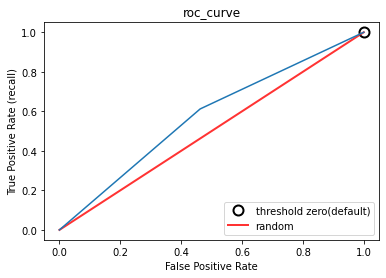

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testy, pred)

# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))

plt.plot(fpr[close_zero], tpr[close_zero], 'o', 
         markersize=10, label="threshold zero(default)", fillstyle="none", c='k', mew=2)
plt.plot([0,1], linestyle='-', lw=2, color='r', label='random', alpha=0.8)
plt.legend(loc=4)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
plt.title("roc_curve");

from sklearn.metrics import auc
print("AUC score is: ", auc(fpr, tpr));

**CONCATENATED MODEL**

In [37]:
nlp_input = Input(shape=(SEQUENCE_LENGTH,)) 
meta_input = Input(shape=(2,))
                   
emb=Embedding(vocab_size,W2V_SIZE,weights=[embedding_matrix],input_length=SEQUENCE_LENGTH,trainable = False)(nlp_input)
nlp_out = LSTM(128)(emb) 

concat = concatenate([nlp_out, meta_input]) 
                        
classifier = Dense(128, activation='relu')(concat) 

output = Dense(1, activation='sigmoid')(classifier) 

model2 = Model(inputs=[nlp_input , meta_input], outputs=[output])

In [38]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 180, 48)      1297488     input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128)          90624       embedding_2[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2)            0                                            
____________________________________________________________________________________________

In [40]:
historyx = model2.fit([x_data,data_meta_input],y_data,batch_size=32,epochs=3,
                    validation_data=([vx_data,val_meta_input],vy_data))

Train on 15000 samples, validate on 1000 samples
Epoch 1/3
15000/15000 [==============================] - 76s 5ms/step - loss: 0.5229 - accuracy: 0.7641 - val_loss: 0.5392 - val_accuracy: 0.7590
Epoch 2/3
15000/15000 [==============================] - 77s 5ms/step - loss: 0.4404 - accuracy: 0.8115 - val_loss: 0.5191 - val_accuracy: 0.7590
Epoch 3/3
15000/15000 [==============================] - 77s 5ms/step - loss: 0.3899 - accuracy: 0.8360 - val_loss: 0.5453 - val_accuracy: 0.7620


In [41]:
historyx = model2.fit([x_data,data_meta_input],y_data,batch_size=32,epochs=5,initial_epoch=3,
                    validation_data=([vx_data,val_meta_input],vy_data))

Train on 15000 samples, validate on 1000 samples
Epoch 4/5
15000/15000 [==============================] - 76s 5ms/step - loss: 0.3377 - accuracy: 0.8579 - val_loss: 0.5798 - val_accuracy: 0.7510
Epoch 5/5
15000/15000 [==============================] - 76s 5ms/step - loss: 0.2741 - accuracy: 0.8876 - val_loss: 0.6413 - val_accuracy: 0.7510


In [42]:
model2.save("Word2Vec_V2.hdf5")

In [43]:
pred = model2.predict([testx,test_data_meta_input])
pred = (pred>0.5)

In [44]:
pred = pred.reshape(5000).astype(int)
np.unique(pred , return_counts=True)

(array([0, 1]), array([2713, 2287]))

In [45]:
confusion_matrix(pred,testy)

array([[2002,  711],
       [ 498, 1789]])

AUC score is:  0.7582


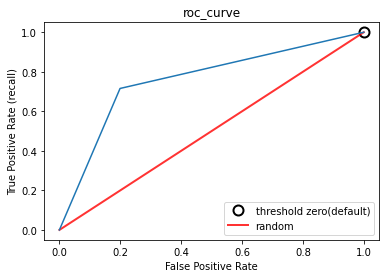

In [46]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testy, pred)

# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))

plt.plot(fpr[close_zero], tpr[close_zero], 'o', 
         markersize=10, label="threshold zero(default)", fillstyle="none", c='k', mew=2)
plt.plot([0,1], linestyle='-', lw=2, color='r', label='random', alpha=0.8)
plt.legend(loc=4)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
plt.title("roc_curve");

from sklearn.metrics import auc
print("AUC score is: ", auc(fpr, tpr));